In [2]:
import pandas as pd
import os

In [3]:
raw_data = pd.read_csv(os.path.join(os.getcwd(), 'Cleaned_Signal_EURUSD_for_training.csv'))

In [4]:
df = raw_data
if 'Unnamed: 0' in df.columns:
    df.drop(columns=['Unnamed: 0'], inplace=True)
df['Date'] = pd.to_datetime(df['time'], unit='s')   
df = df[['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Signal']]
df.set_index('Date', inplace=True)
df

,Open,High,Low,Close,Volume,Signal
Date,,,,,,
2014-12-31 18:00:00,1.20997,1.21089,1.20966,1.20999,3237,0
2015-01-02 08:00:00,1.20481,1.20569,1.20479,1.20538,1254,0
2015-01-02 09:00:00,1.20537,1.20574,1.20341,1.20553,3394,0
2015-01-02 10:00:00,1.20556,1.20689,1.20442,1.20469,4590,0
2015-01-02 11:00:00,1.20468,1.20599,1.20380,1.20573,4335,0
...,...,...,...,...,...,...
2024-12-20 10:00:00,1.03816,1.03974,1.03770,1.03913,5104,1
2024-12-20 11:00:00,1.03913,1.03915,1.03749,1.03817,4389,1
2024-12-20 12:00:00,1.03818,1.03921,1.03803,1.03908,3521,1


In [6]:
raw_data = df

In [5]:
import pandas as pd
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler, SMOTE
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
# from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from collections import Counter
from sklearn.metrics import confusion_matrix

from operator import itemgetter
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif, RFE
from sklearn.linear_model import LassoCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report

In [6]:
# file_name = 'merged_data.csv'
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
data_path = os.path.join(os.getcwd(), data_dir, file_name)

data = pd.read_csv(data_path, index_col=0)
data.reset_index(drop=True, inplace=True)
data.head()

,Open,High,Low,Close,Volume,Time,Date,Signal,Moving_Avg,Upper_Band,Lower_Band
0,1.20997,1.21089,1.20966,1.20999,3237,2014-12-31 18:00:00,2014-12-31 18:00:00,0,NaN,NaN,NaN
1,1.20481,1.20569,1.20479,1.20538,1254,2015-01-02 08:00:00,2015-01-02 08:00:00,0,NaN,NaN,NaN
2,1.20537,1.20574,1.20341,1.20553,3394,2015-01-02 09:00:00,2015-01-02 09:00:00,0,NaN,NaN,NaN
3,1.20556,1.20689,1.20442,1.20469,4590,2015-01-02 10:00:00,2015-01-02 10:00:00,0,NaN,NaN,NaN
4,1.20468,1.20599,1.20380,1.20573,4335,2015-01-02 11:00:00,2015-01-02 11:00:00,0,NaN,NaN,NaN


In [7]:
data = df

In [8]:
data['Signal'].value_counts()

Signal
 0    27544
-1    17503
 1    16891
Name: count, dtype: int64

###  Desired logic:
#### Initially all zeros.
#### When you hit a 1 or 2, keep repeating that value until the next non-zero (different) signal appears.
#### If 0 appears after a 1 or 2, treat it as "repeat the last non-zero". 
#### Propagate the last non-zero signal forward until a new one appears.
#### If any span of a propagated signal (1 or 2) is less than 10 in length, replace it with 0.

In [26]:
# import numpy as np

# # Input signal (replace with your actual data)
# signal = np.array([
#     0, 0, 0, 0, 2, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0,
#     0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1,
#     1, 0, 0, 0
# ], dtype=int)

signal = data.Signal.values
Threshold = 100

# Step 1: Propagate signals forward
output = np.zeros_like(signal)
last = 0
for i, val in enumerate(signal):
    if val != 0:
        last = val
    output[i] = last
print('Before', output)
# Step 2: Remove short signal spans (less than 10)
i = 0
while i < len(output):
    val = output[i]
    if val == 0:
        i += 1
        continue
    # Count span length
    start = i
    while i < len(output) and output[i] == val:
        i += 1
    end = i
    span = end - start
    if span < Threshold:
        output[start:end] = 0

# print(output)


Before [0 0 0 ... 1 1 1]


In [27]:
data['signal_balanced'] = output

In [28]:
data['signal_balanced'].value_counts()

signal_balanced
1    23616
2    21962
0    16360
Name: count, dtype: int64

In [16]:
# file_name = 'merged_data.csv'
file_name = '0_61938.csv'
data_dir = 'ohlc_data'
data_path = os.path.join(os.getcwd(), data_dir, file_name)

data = pd.read_csv(data_path, index_col=0)
data.reset_index(drop=True, inplace=True)




NameError: name 'feature_generate' is not defined

In [16]:
data = raw_data

In [17]:
features_df = feature_generate(data)

In [19]:
features_df.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Signal', 'SMA_5', 'EMA_5',
       'SMA_10', 'EMA_10', 'SMA_20', 'EMA_20', 'SMA_50', 'EMA_50', 'SMA_100',
       'EMA_100', 'SMA_200', 'EMA_200', 'RSI_14', 'Stochastic_K',
       'Stochastic_D', 'Williams_%R', 'MACD', 'MACD_Signal', 'MACD_Hist',
       'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'CCI', 'Bollinger_Mid',
       'Bollinger_Upper', 'Bollinger_Lower', 'ROC', 'OBV', 'Force_Index',
       'ADL', 'MFI', 'ASI', 'Chaikin_Oscillator', 'RS', 'Keltner_Mid',
       'Keltner_Upper', 'Keltner_Lower', 'Donchian_Upper', 'Donchian_Lower',
       'Tenkan_Sen', 'Kijun_Sen', 'Senkou_Span_A', 'Senkou_Span_B', 'Fib_0',
       'Fib_100', 'Fib_50', 'Fib_61.8', 'Fib_38.2', 'Double_Top',
       'Double_Bottom', 'Channel_High', 'Channel_Low', 'Channel_Mid',
       'LR_Center', 'LR_Upper', 'LR_Lower', 'SAR', 'Std_Dev_Upper',
       'Std_Dev_Lower', 'VWAP', 'VWAP_Upper', 'VWAP_Lower', 'Adaptive_Upper',
       'Adaptive_Lower', 'HA_Close', 'HA_Open', 'Pivot_P

In [23]:
features_df.isna().any(axis=1).sum()

61938

In [24]:
features_df = features_df.fillna(method='ffill').fillna(method='bfill')

In [27]:
features_df.columns[features_df.isna().all()]

Index(['Plus_DI', 'Minus_DI', 'ADX', 'MFI'], dtype='object')

In [14]:


features_df_nonan = features_df.dropna().reset_index(drop=True)

features_df_nonan['Signal'].value_counts()

selected_features_, feat_idx_ = features_selection(features_df_nonan)

Features removed due to high correlation: []


ValueError: Found array with 0 sample(s) (shape=(0, 75)) while a minimum of 1 is required by StandardScaler.

In [11]:
features_df

,Open,High,Low,Close,Volume,Signal,SMA_5,EMA_5,SMA_10,EMA_10,...,VWAP,VWAP_Upper,VWAP_Lower,Adaptive_Upper,Adaptive_Lower,HA_Close,HA_Open,Pivot_Point,Pivot_R1,Pivot_S1
Date,,,,,,,,,,,,,,,,,,,,,
2014-12-31 18:00:00,1.20997,1.21089,1.20966,1.20999,3237,0,NaN,1.209990,NaN,1.209990,...,1.209990,NaN,NaN,NaN,NaN,1.210128,NaN,1.210180,1.210700,1.209470
2015-01-02 08:00:00,1.20481,1.20569,1.20479,1.20538,1254,0,NaN,1.208453,NaN,1.209152,...,1.208703,NaN,NaN,NaN,NaN,1.205167,1.210128,1.205287,1.205783,1.204883
2015-01-02 09:00:00,1.20537,1.20574,1.20341,1.20553,3394,0,NaN,1.207479,NaN,1.208493,...,1.207337,NaN,NaN,NaN,NaN,1.205013,1.205167,1.204893,1.206377,1.204047
2015-01-02 10:00:00,1.20556,1.20689,1.20442,1.20469,4590,0,NaN,1.206549,NaN,1.207802,...,1.206363,NaN,NaN,NaN,NaN,1.205390,1.205013,1.205333,1.206247,1.203777
2015-01-02 11:00:00,1.20468,1.20599,1.20380,1.20573,4335,0,1.206264,1.206276,NaN,1.207425,...,1.206200,NaN,NaN,NaN,NaN,1.205050,1.205390,1.205173,1.206547,1.204357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20 10:00:00,1.03816,1.03974,1.03770,1.03913,5104,1,1.037396,1.037799,1.036832,1.037288,...,1.112626,1.113907,1.111346,1.041044,1.037216,1.038683,1.037777,1.038857,1.040013,1.037973
2024-12-20 11:00:00,1.03913,1.03915,1.03749,1.03817,4389,1,1.037874,1.037923,1.037015,1.037449,...,1.112624,1.113761,1.111488,1.040206,1.036134,1.038485,1.038683,1.038270,1.039050,1.037390
2024-12-20 12:00:00,1.03818,1.03921,1.03803,1.03908,3521,1,1.038386,1.038309,1.037282,1.037745,...,1.112623,1.113716,1.111530,1.041447,1.036713,1.038625,1.038485,1.038773,1.039517,1.038337


In [5]:
features_df_nonan.iloc[:, feat_idx_].columns

Index(['High', 'Low', 'Close', 'Volume', 'Time', 'Date', 'SMA_5', 'SMA_10',
       'SMA_20', 'EMA_20', 'SMA_50', 'SMA_100', 'EMA_100', 'SMA_200',
       'EMA_200', 'RSI_14', 'Stochastic_K', 'Stochastic_D', 'MACD_Signal',
       'MACD_Hist', 'ATR', 'Plus_DI', 'Minus_DI', 'ADX', 'CCI',
       'Bollinger_Mid', 'ROC', 'OBV', 'Force_Index', 'ADL', 'MFI', 'ASI',
       'Chaikin_Oscillator', 'RS', 'Keltner_Mid', 'Keltner_Upper',
       'Keltner_Lower', 'Donchian_Lower', 'Kijun_Sen', 'Senkou_Span_A',
       'Senkou_Span_B', 'Fib_0'],
      dtype='object')

In [6]:
if 'Date' in features_df_nonan.iloc[:, feat_idx_].columns:
    features_df_nonan = features_df_nonan.drop(columns=['Date'])
elif 'Time' in features_df_nonan.iloc[:, feat_idx_].columns:
    features_df_nonan = features_df_nonan.drop(columns=['Time'])

features_df_nonan = features_df_nonan.select_dtypes(exclude=['object'])

epoch = 10

model_name = os.path.join(os.getcwd(), data_dir)
xTest, yTest_onehot, history_, model_path = prepare_train_model(
    features_df_nonan.iloc[:, feat_idx_], 
    features_df_nonan['Signal'],
    epoch,
    model_name)



train_split = 0.8
Shape of x, y train/cv/test: (114547, 42) (114547,) (28637, 42) (28637,) (12348, 42) (12348,)
Unique class labels before encoding: [0 1 2]
Class Label: 0 -> One-Hot Encoding: [1. 0. 0.]
Class Label: 1 -> One-Hot Encoding: [0. 1. 0.]
Class Label: 2 -> One-Hot Encoding: [0. 0. 1.]
Epoch 1/10
3580/3580 [==============================] - 15s 4ms/step - loss: 0.0253 - accuracy: 0.9908 - val_loss: 3.4009e-07 - val_accuracy: 1.0000
Epoch 2/10
3580/3580 [==============================] - 13s 4ms/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 5.0979e-07 - val_accuracy: 1.0000
Epoch 3/10
3580/3580 [==============================] - 14s 4ms/step - loss: 8.8737e-04 - accuracy: 0.9997 - val_loss: 3.8093e-08 - val_accuracy: 1.0000
Epoch 4/10
3580/3580 [==============================] - 13s 4ms/step - loss: 6.4998e-04 - accuracy: 0.9998 - val_loss: 9.1330e-09 - val_accuracy: 1.0000
Epoch 5/10
3580/3580 [==============================] - 13s 4ms/step - loss: 1.7164e-04 - accuracy

INFO:tensorflow:Assets written to: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\model.hd5\assets


In [20]:
len(feat_idx_)

42

In [15]:
xTest.shape

(12348, 42, 1)

In [14]:
model_path

'D:\\git_repos\\Make_Money_with_Tensorflow_2.0\\forexPredictor\\ohlc_data'

386/386 [==============================] - 1s 1ms/step
Predicted one hot: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0]
Actual one hot: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0]
[[11932     0     0]
 [    0   204     0]
 [    0     0   212]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     11932
           1       1.00      1.00      1.00       204
           2       1.00      1.00      1.00       212

    accuracy                           1.00     12348
   macro avg       1.00      1.00      1.00     12348
weighted avg       1.00      1.00      1.00     12348



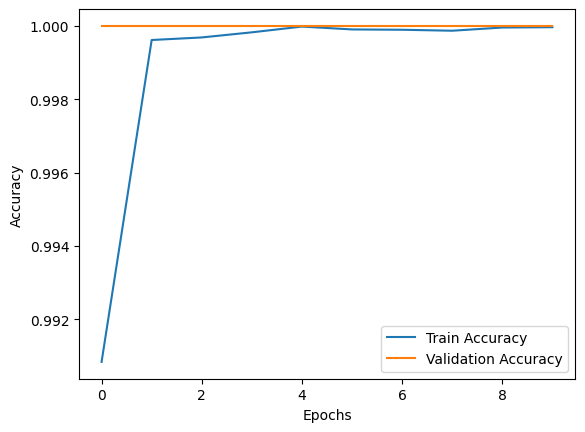

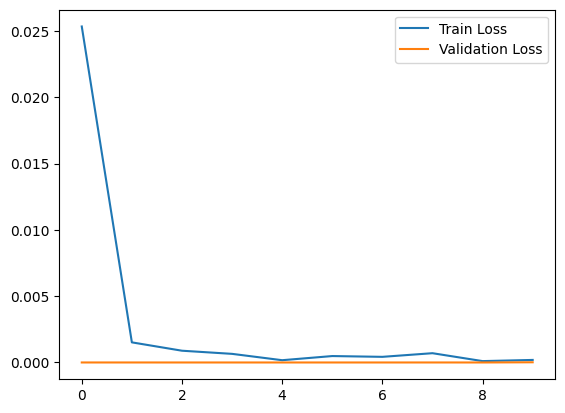

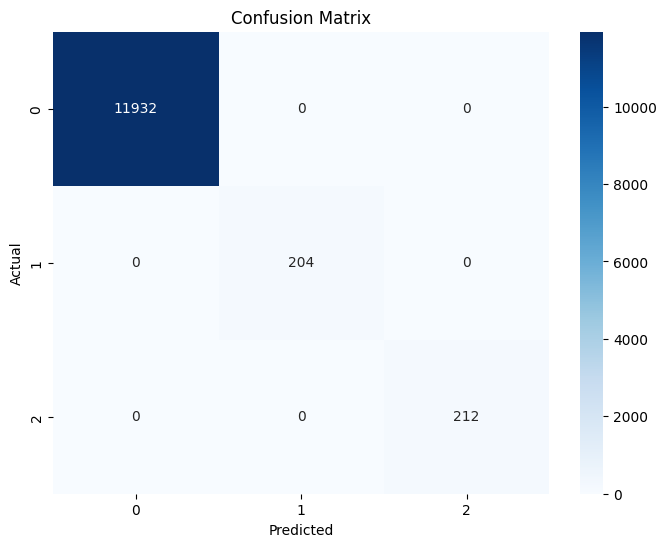

In [7]:
predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)  

In [9]:
def prepare_train_model(df, df_signal, epc, model_saved_path):
    # Exclude the 'Signal' column and select only numeric data
#     X = df.drop(columns=['Signal']).select_dtypes(include=[np.number]).values
#     y = df['Signal'].values  # Target variable
    X = df.values
    y = df_signal.values
    # Splitting the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=0.8, 
        test_size=0.2, 
        random_state=2, 
        shuffle=True, 
        stratify=y
    )

    # Uncomment the following lines if you want to handle class imbalance
    # 'not majority': resample all classes but the majority class
#     smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
#     x_train, y_train = smote.fit_resample(x_train, y_train)
#     print('Resampled dataset shape:', Counter(y_train))

    smote = SMOTE(random_state=42, sampling_strategy='not majority')
    x_train, y_train = smote.fit_resample(x_train, y_train)


    # Dynamic train-validation split
    train_split = 0.9 if 0.8 * x_train.shape[0] < 2500 else 0.8
    print('train_split =', train_split)

    # Split the training set further into training and cross-validation sets
    x_train, x_cv, y_train, y_cv = train_test_split(
        x_train, y_train, 
        train_size=train_split, 
        test_size=1-train_split, 
        random_state=2, 
        shuffle=True, 
        stratify=y_train
    )

    # Choose between MinMaxScaler or StandardScaler
    scaler = MinMaxScaler(feature_range=(0, 1))  # For Min-Max scaling
    # scaler = StandardScaler()                   # For Standard scaling

    # Apply scaling to training, cross-validation, and test sets
    x_train = scaler.fit_transform(x_train)
    x_cv = scaler.transform(x_cv)
    x_test = scaler.transform(x_test)

    # Copying the main training set for further operations if needed
    x_main = x_train.copy()

    # Printing the shapes of train, cross-validation, and test sets
    print("Shape of x, y train/cv/test:", 
          x_train.shape, y_train.shape, x_cv.shape, y_cv.shape, x_test.shape, y_test.shape)


    # Ensure reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)

    # Reshape inputs for CNN
    x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))  # Add channel dimension
    x_cv = x_cv.reshape((x_cv.shape[0], x_cv.shape[1], 1))
    x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

    # Normalize data if not already normalized
    x_train = x_train / np.max(x_train)
    x_cv = x_cv / np.max(x_cv)
    x_test = x_test / np.max(x_test)
    
    # Print unique labels before encoding
    print("Unique class labels before encoding:", np.unique(y_train))
    
    y_train_onehot = to_categorical(y_train, num_classes=3)
    y_cv_onehot = to_categorical(y_cv, num_classes=3)
    y_test_onehot = to_categorical(y_test, num_classes=3)
    
    # Get unique class labels in y_train
    unique_labels = np.unique(y_train)

    # Print one-hot encoding for each unique label
    for label in unique_labels:
        onehot = to_categorical([label], num_classes=3)[0]  # Convert single label to one-hot
        print(f"Class Label: {label} -> One-Hot Encoding: {onehot}")


    model = Sequential([
        Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
        MaxPooling1D(pool_size=2),
        Dropout(0.2),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
    ])

    ## If One hot encoded
    model.compile(optimizer='adam', 
                  loss='categorical_crossentropy', 
                  metrics=['accuracy'])


    class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_train),
    y=y_train)
    
    class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

    ### If one hot encoded
    history = model.fit(x_train, y_train_onehot, 
                        epochs=epc, 
                        batch_size=32, 
                        validation_data=(x_cv, y_cv_onehot),
                        class_weight=class_weight_dict)

    # if One hot the Evaluate the model like below
    test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_accuracy:.4f}")

    # Save the model to a file
    model.save(os.path.join(model_saved_path, 'model.hd5'))  # Saves the model in HDF5 format (recommended for compatibility)
    # model = load_model("my_model.h5")
    
    return x_test, y_test_onehot, history, model_saved_path

def predictions_accuracy_plot(x_test, y_test_onehot, history, model_saved_path):
    
    model = load_model(os.path.join(model_saved_path, 'model.hd5'))
    
    # Get predictions
    y_pred = model.predict(x_test)  # This returns probabilities
    y_pred_classes = np.argmax(y_pred, axis=1)  # Convert probabilities to class indices

    # Convert one-hot encoded y_test back to class indices for comparison
    y_test_classes = np.argmax(y_test_onehot, axis=1)
        
    # Convert predictions back to original labels
#     mapping = {0: 0, 1: 1, 2: 2}  # Reverse mapping
#     y_pred_original = np.vectorize(mapping.get)(y_pred_classes)
    
    # Check some predictions
    print("Predicted one hot:", y_pred_classes[:50])
    print("Actual one hot:", y_test_classes[:50])
#     print("Original:", y_pred_original[:50])

    conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)
    print(conf_matrix)
    print(classification_report(y_test_classes, y_pred_classes))

    import matplotlib.pyplot as plt

    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.show()

    # one hot encoded Create a heatmap
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    

    

def features_selection(df, selection_method='all', topk=10, num_features=225):
    
    # Check if the columns exist before dropping
    columns_to_drop = ['Time', 'Date', 'Signal']
    X = df.drop(columns=[col for col in columns_to_drop if col in df.columns])
    
    # Separate features and target variable
    y = df['Signal']  # Target variable
    
    # Ensure that only numeric columns are used for correlation
    X_numeric = X.select_dtypes(include=[np.number])

    # Step 1: Correlation Matrix
    # Remove highly correlated features
    cor_matrix = X_numeric.corr().abs()
    upper_triangle = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))
    high_corr_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.9999)]
    X.drop(columns=high_corr_features, inplace=True)
    print(f"Features removed due to high correlation: {high_corr_features}")

    # Step 2: Feature Selection with Lasso
    # Scale the data before Lasso
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # Apply LassoCV for feature selection
    lasso = LassoCV(cv=5, random_state=0).fit(X_scaled, y)
    lasso_selected_features = X.columns[lasso.coef_ != 0]
    print(f"Features selected by Lasso: {list(lasso_selected_features)}")

    list_features = X.columns.tolist()  # List of all feature names

    # Get indices of common features
    feat_idx = sorted([list_features.index(c) for c in lasso_selected_features][:num_features])
    print("Feature indices for common features:", feat_idx)

    return lasso_selected_features, feat_idx

def feature_generate(indicators_df):    
    # Moving Averages (Simple and Exponential)
    for window in [5, 10, 20, 50, 100, 200]:
        indicators_df[f'SMA_{window}'] = indicators_df['Close'].rolling(window=window).mean()
        indicators_df[f'EMA_{window}'] = indicators_df['Close'].ewm(span=window, adjust=False).mean()

    # Momentum Indicators
    indicators_df['RSI_14'] = 100 - (100 / (1 + (indicators_df['Close'].diff().clip(lower=0).rolling(window=14).mean() / 
                                                  indicators_df['Close'].diff().clip(upper=0).abs().rolling(window=14).mean())))

    indicators_df['Stochastic_K'] = ((indicators_df['Close'] - indicators_df['Low'].rolling(14).min()) /
                                      (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * 100

    indicators_df['Stochastic_D'] = indicators_df['Stochastic_K'].rolling(3).mean()

    # Williams %R
    indicators_df['Williams_%R'] = ((indicators_df['High'].rolling(14).max() - indicators_df['Close']) /
                                     (indicators_df['High'].rolling(14).max() - indicators_df['Low'].rolling(14).min())) * -100

    # Moving Average Convergence Divergence (MACD)
    indicators_df['MACD'] = indicators_df['Close'].ewm(span=12, adjust=False).mean() - indicators_df['Close'].ewm(span=26, adjust=False).mean()
    indicators_df['MACD_Signal'] = indicators_df['MACD'].ewm(span=9, adjust=False).mean()
    indicators_df['MACD_Hist'] = indicators_df['MACD'] - indicators_df['MACD_Signal']

    # Average Directional Index (ADX)
    high_diff = indicators_df['High'].diff()
    low_diff = indicators_df['Low'].diff()
    plus_dm = np.where((high_diff > low_diff) & (high_diff > 0), high_diff, 0)
    minus_dm = np.where((low_diff > high_diff) & (low_diff > 0), low_diff, 0)
    true_range = pd.DataFrame({
        'hl': indicators_df['High'] - indicators_df['Low'],
        'hc': (indicators_df['High'] - indicators_df['Close'].shift()).abs(),
        'lc': (indicators_df['Low'] - indicators_df['Close'].shift()).abs()
    }).max(axis=1)
    indicators_df['ATR'] = true_range.rolling(window=14).mean()
    indicators_df['Plus_DI'] = 100 * pd.Series(plus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['Minus_DI'] = 100 * pd.Series(minus_dm).rolling(window=14).mean() / indicators_df['ATR']
    indicators_df['ADX'] = 100 * abs(indicators_df['Plus_DI'] - indicators_df['Minus_DI']).rolling(window=14).mean() / (indicators_df['Plus_DI'] + indicators_df['Minus_DI'])

    # Commodity Channel Index (CCI)
    typical_price = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['CCI'] = (typical_price - typical_price.rolling(20).mean()) / (0.015 * typical_price.rolling(20).std())

    # Bollinger Bands
    indicators_df['Bollinger_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Bollinger_Upper'] = indicators_df['Bollinger_Mid'] + 2 * indicators_df['Close'].rolling(window=20).std()
    indicators_df['Bollinger_Lower'] = indicators_df['Bollinger_Mid'] - 2 * indicators_df['Close'].rolling(window=20).std()

    # Rate of Change (ROC)
    indicators_df['ROC'] = indicators_df['Close'].pct_change(periods=12) * 100

    # On-Balance Volume (OBV)
    obv = np.where(indicators_df['Close'] > indicators_df['Close'].shift(1), indicators_df['Volume'],
                   np.where(indicators_df['Close'] < indicators_df['Close'].shift(1), -indicators_df['Volume'], 0))
    indicators_df['OBV'] = obv.cumsum()

    # Force Index
    indicators_df['Force_Index'] = indicators_df['Close'].diff(1) * indicators_df['Volume']

    # Accumulation/Distribution Line (ADL)
    adl = ((indicators_df['Close'] - indicators_df['Low']) - (indicators_df['High'] - indicators_df['Close'])) / \
           (indicators_df['High'] - indicators_df['Low']) * indicators_df['Volume']
    indicators_df['ADL'] = adl.cumsum()

    # Money Flow Index (MFI)
    money_flow = typical_price * indicators_df['Volume']
    positive_flow = np.where(typical_price > typical_price.shift(1), money_flow, 0)
    negative_flow = np.where(typical_price < typical_price.shift(1), money_flow, 0)
    mfi_ratio = pd.Series(positive_flow).rolling(14).sum() / pd.Series(negative_flow).rolling(14).sum()
    indicators_df['MFI'] = 100 - (100 / (1 + mfi_ratio))

    # Accumulation Swing Index (ASI)
    indicators_df['ASI'] = ((indicators_df['Close'] - indicators_df['Close'].shift()) +
                            (0.5 * (indicators_df['Close'] - indicators_df['Open'])) +
                            (0.25 * (indicators_df['Close'].shift() - indicators_df['Open'].shift()))) / indicators_df['ATR']

    # Chaikin Oscillator
    indicators_df['Chaikin_Oscillator'] = indicators_df['ADL'].ewm(span=3, adjust=False).mean() - indicators_df['ADL'].ewm(span=10, adjust=False).mean()

    # Relative Strength (RS)
    indicators_df['RS'] = indicators_df['Close'] / indicators_df['Close'].rolling(14).mean()

    # Keltner Channels
    indicators_df['Keltner_Mid'] = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Keltner_Upper'] = indicators_df['Keltner_Mid'] + 1.5 * indicators_df['ATR']
    indicators_df['Keltner_Lower'] = indicators_df['Keltner_Mid'] - 1.5 * indicators_df['ATR']

    # Donchian Channels
    indicators_df['Donchian_Upper'] = indicators_df['High'].rolling(window=20).max()
    indicators_df['Donchian_Lower'] = indicators_df['Low'].rolling(window=20).min()

    # Ichimoku Cloud
    indicators_df['Tenkan_Sen'] = (indicators_df['High'].rolling(9).max() + indicators_df['Low'].rolling(9).min()) / 2
    indicators_df['Kijun_Sen'] = (indicators_df['High'].rolling(26).max() + indicators_df['Low'].rolling(26).min()) / 2
    indicators_df['Senkou_Span_A'] = ((indicators_df['Tenkan_Sen'] + indicators_df['Kijun_Sen']) / 2).shift(26)
    indicators_df['Senkou_Span_B'] = ((indicators_df['High'].rolling(52).max() + indicators_df['Low'].rolling(52).min()) / 2).shift(26)

    # Fibonacci Retracement Levels
    indicators_df['Fib_0'] = indicators_df['Close'].rolling(window=20).min()
    indicators_df['Fib_100'] = indicators_df['Close'].rolling(window=20).max()
    indicators_df['Fib_50'] = (indicators_df['Fib_0'] + indicators_df['Fib_100']) / 2
    indicators_df['Fib_61.8'] = indicators_df['Fib_0'] + ((indicators_df['Fib_100'] - indicators_df['Fib_0']) * 0.618)
    indicators_df['Fib_38.2'] = indicators_df['Fib_0'] + ((indicators_df['Fib_100'] - indicators_df['Fib_0']) * 0.382)

        # Double/Triple Tops and Bottoms
    indicators_df['Double_Top'] = (indicators_df['High'].rolling(window=3).max() == indicators_df['High'])
    indicators_df['Double_Bottom'] = (indicators_df['Low'].rolling(window=3).min() == indicators_df['Low'])

    # Price Channels
    indicators_df['Channel_High'] = indicators_df['High'].rolling(window=20).max()
    indicators_df['Channel_Low'] = indicators_df['Low'].rolling(window=20).min()
    indicators_df['Channel_Mid'] = (indicators_df['Channel_High'] + indicators_df['Channel_Low']) / 2

    # Linear Regression Channels
    def linear_regression_channel(series, window):
        x = np.arange(window)
        fit = lambda y: np.polyfit(x, y, 1)
        slope, intercept = series.rolling(window).apply(lambda y: fit(y)[0], raw=False), series.rolling(window).apply(lambda y: fit(y)[1], raw=False)
        center = slope * (window - 1) + intercept
        std = series.rolling(window).std()
        return center, center + 2 * std, center - 2 * std

    lr_center, lr_upper, lr_lower = linear_regression_channel(indicators_df['Close'], 20)
    indicators_df['LR_Center'] = lr_center
    indicators_df['LR_Upper'] = lr_upper
    indicators_df['LR_Lower'] = lr_lower

    # Parabolic SAR (Modified for Channels)
    sar = indicators_df['Low'].rolling(window=14).min()
    indicators_df['SAR'] = sar.shift(1)

    # Standard Deviation Channels
    std = indicators_df['Close'].rolling(window=20).std()
    mean = indicators_df['Close'].rolling(window=20).mean()
    indicators_df['Std_Dev_Upper'] = mean + 2 * std
    indicators_df['Std_Dev_Lower'] = mean - 2 * std

    # VWAP Bands
    indicators_df['VWAP'] = (indicators_df['Close'] * indicators_df['Volume']).cumsum() / indicators_df['Volume'].cumsum()
    indicators_df['VWAP_Upper'] = indicators_df['VWAP'] + std
    indicators_df['VWAP_Lower'] = indicators_df['VWAP'] - std

    # Adaptive Channels
    atr = indicators_df['Close'].rolling(window=14).std()
    indicators_df['Adaptive_Upper'] = indicators_df['Close'] + (2 * atr)
    indicators_df['Adaptive_Lower'] = indicators_df['Close'] - (2 * atr)

    # Heikin-Ashi
    ha_close = (indicators_df['Open'] + indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 4
    indicators_df['HA_Close'] = ha_close
    indicators_df['HA_Open'] = ha_close.shift(1)

    # Pivot Points
    pivot = (indicators_df['High'] + indicators_df['Low'] + indicators_df['Close']) / 3
    indicators_df['Pivot_Point'] = pivot
    indicators_df['Pivot_R1'] = (2 * pivot) - indicators_df['Low']
    indicators_df['Pivot_S1'] = (2 * pivot) - indicators_df['High']

    
    return indicators_df


In [24]:
model_name = os.path.join(os.getcwd(), data_dir)
xTest, yTest_onehot, history_, model_path = prepare_train_model_with_comparison(
    features_df_nonan.iloc[:, feat_idx_], 
    features_df_nonan['Signal'],
    model_name)

386/386 [==============================] - 1s 2ms/step


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

Method: Original, Test Accuracy: 0.9270
Random Oversampling dataset shape: Counter({0: 45356, 1: 45356, -1: 45356})
386/386 [==============================] - 1s 2ms/step
Method: Random Oversampling, Test Accuracy: 0.7772
Random Undersampling dataset shape: Counter({-1: 2009, 0: 2009, 1: 2009})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

386/386 [==============================] - 1s 2ms/step


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

Method: Random Undersampling, Test Accuracy: 0.7332
SMOTE dataset shape: Counter({0: 45356, 1: 45356, -1: 45356})
386/386 [==============================] - 1s 3ms/step


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

Method: SMOTE, Test Accuracy: 0.7428
ADASYN dataset shape: Counter({-1: 45403, 0: 45356, 1: 45331})
386/386 [==============================] - 1s 3ms/step
Method: ADASYN, Test Accuracy: 0.6856


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, m

INFO:tensorflow:Assets written to: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\assets


INFO:tensorflow:Assets written to: D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\assets


Best Method: Original, Accuracy: 0.9270


ValueError: too many values to unpack (expected 4)

In [2]:
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

def prepare_train_model_with_comparison(df, df_signal, model_saved_path):
    X = df.values
    y = df_signal.values

    # Splitting the data into train and test sets
    x_train, x_test, y_train, y_test = train_test_split(
        X, y, 
        train_size=0.8, 
        test_size=0.2, 
        random_state=42, 
        shuffle=True, 
        stratify=y
    )

    # Different imbalance handling methods
    methods = {
        'Original': None,
        'Random Oversampling': RandomOverSampler(sampling_strategy='minority'),
        'Random Undersampling': RandomUnderSampler(sampling_strategy='majority'),
        'SMOTE': SMOTE(random_state=42),
        'ADASYN': ADASYN(random_state=42),
    }

    results = {}
    for method_name, sampler in methods.items():
        if sampler:
            x_train_resampled, y_train_resampled = sampler.fit_resample(x_train, y_train)
            print(f'{method_name} dataset shape:', Counter(y_train_resampled))
        else:
            x_train_resampled, y_train_resampled = x_train, y_train

        # Normalize the data
        scaler = MinMaxScaler()
        x_train_resampled = scaler.fit_transform(x_train_resampled)
        x_test_scaled = scaler.transform(x_test)

        # Reshape inputs for CNN
        x_train_resampled = x_train_resampled.reshape((x_train_resampled.shape[0], x_train_resampled.shape[1], 1))
        x_test_scaled = x_test_scaled.reshape((x_test_scaled.shape[0], x_test_scaled.shape[1], 1))

        # One-hot encoding for the target variable
        y_train_onehot = to_categorical(y_train_resampled, num_classes=3)
        y_test_onehot = to_categorical(y_test, num_classes=3)

        # Define the CNN model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train_resampled.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')
        ])

        # Compile and train the model
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        history = model.fit(x_train_resampled, y_train_onehot, epochs=10, batch_size=32, verbose=0)

        # Evaluate the model
        test_loss, test_accuracy = model.evaluate(x_test_scaled, y_test_onehot, verbose=0)
        y_pred = np.argmax(model.predict(x_test_scaled), axis=1)
        classification_report_str = classification_report(y_test, y_pred, output_dict=True)

        results[method_name] = {
            'Test Accuracy': test_accuracy,
            'Classification Report': classification_report_str,
            'Confusion Matrix': confusion_matrix(y_test, y_pred),
        }
        print(f'Method: {method_name}, Test Accuracy: {test_accuracy:.4f}')

    # Save the best model if needed
    best_method = max(results, key=lambda m: results[m]['Test Accuracy'])
    model.save(model_saved_path)

    print(f"Best Method: {best_method}, Accuracy: {results[best_method]['Test Accuracy']:.4f}")
    return results


In [58]:
model_dir = 'models'
fold = True

dataset_feature_engineered = features_df_nonan.iloc[:, feat_idx_]
dataset_feature_engineered_no = features_df_nonan


if fold is True:
    model_dir_name = os.path.join(os.getcwd(), data_dir, model_dir)
    accuracies, histories = prepare_train_model_with_kfold(dataset_feature_engineered, model_dir_name)
# #         predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)
    print('Accuracy: ', accuracies)
# else:
#     model_name = os.path.join(os.getcwd(), data_dir, i)
#     xTest, yTest_onehot, history_, model_path = prepare_train_model(features_df_nonan, 
#                                                                     model_name)
#     predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)        
        
        

Fold 1/5
Resampled dataset shape: Counter({0: 48756, 1: 48756, -1: 48756})
4571/4571 [==============================] - 17s 4ms/step - loss: 0.4930 - accuracy: 0.7855 - val_loss: 0.6619 - val_accuracy: 0.6410
Fold 1 - Test Loss: 0.6619, Test Accuracy: 0.6410
Fold 2/5
Resampled dataset shape: Counter({0: 48757, 1: 48757, -1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 17s 4ms/step - loss: 0.4796 - accuracy: 0.7938 - val_loss: 0.6229 - val_accuracy: 0.6153
Fold 2 - Test Loss: 0.6229, Test Accuracy: 0.6153
Fold 3/5
Resampled dataset shape: Counter({0: 48757, -1: 48757, 1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 17s 4ms/step - loss: 0.4906 - accuracy: 0.7874 - val_loss: 0.6263 - val_accuracy: 0.6351
Fold 3 - Test Loss: 0.6263, Test Accuracy: 0.6351
Fold 4/5
Resampled dataset shape: Counter({0: 48757, 1: 48757, -1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 16s 3ms/step - loss: 0.5027 - accuracy: 0.7816 - val_loss: 0.6072 - val_accuracy: 0.6356
Fold 4 - Test Loss: 0.6072, Test Accuracy: 0.6356
Fold 5/5
Resampled dataset shape: Counter({0: 48757, 1: 48757, -1: 48757})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4571/4571 [==============================] - 17s 4ms/step - loss: 0.4836 - accuracy: 0.7935 - val_loss: 0.5778 - val_accuracy: 0.6739
Fold 5 - Test Loss: 0.5778, Test Accuracy: 0.6739
Average Accuracy across 5 folds: 0.6402
Accuracy per fold: [0.6409944891929626, 0.6153222918510437, 0.6350826025009155, 0.6356495022773743, 0.6739289164543152]
Accuracy:  [0.6409944891929626, 0.6153222918510437, 0.6350826025009155, 0.6356495022773743, 0.6739289164543152]


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [15]:
features_df_nonan

,Open,High,Low,Close,Volume,Date,Signal,SMA_5,EMA_5,SMA_10,...,VWAP,VWAP_Upper,VWAP_Lower,Adaptive_Upper,Adaptive_Lower,HA_Close,HA_Open,Pivot_Point,Pivot_R1,Pivot_S1
0,1.13379,1.13386,1.13234,1.13258,5489,8/19/2016 15:59,0,1.133356,1.133310,1.133501,...,1.126293,1.127106,1.125480,1.133765,1.131395,1.133142,1.133997,1.132927,1.133513,1.131993
1,1.13257,1.13344,1.13195,1.13218,6931,8/19/2016 16:59,0,1.133226,1.132933,1.133343,...,1.126350,1.127171,1.125528,1.133450,1.130910,1.132535,1.133142,1.132523,1.133097,1.131607
2,1.13218,1.13243,1.13064,1.13065,5163,8/19/2016 17:59,0,1.132714,1.132172,1.133034,...,1.126380,1.127328,1.125432,1.132559,1.128741,1.131475,1.132535,1.131240,1.131840,1.130050
3,1.13064,1.13182,1.13045,1.13172,3541,8/19/2016 18:59,0,1.132184,1.132021,1.132882,...,1.126406,1.127365,1.125447,1.133773,1.129667,1.131158,1.131475,1.131330,1.132210,1.130840
4,1.13171,1.13216,1.13100,1.13108,2591,8/19/2016 19:59,0,1.131642,1.131708,1.132551,...,1.126423,1.127442,1.125403,1.133385,1.128775,1.131487,1.131158,1.131413,1.131827,1.130667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61734,1.03816,1.03974,1.03770,1.03913,5104,9/4/2023 21:54,0,1.037396,1.037799,1.036832,...,1.112626,1.113907,1.111346,1.041044,1.037216,1.038683,1.037777,1.038857,1.040013,1.037973
61735,1.03913,1.03915,1.03749,1.03817,4389,9/4/2023 22:54,0,1.037874,1.037923,1.037015,...,1.112624,1.113761,1.111488,1.040206,1.036134,1.038485,1.038683,1.038270,1.039050,1.037390
61736,1.03818,1.03921,1.03803,1.03908,3521,9/4/2023 23:54,0,1.038386,1.038309,1.037282,...,1.112623,1.113716,1.111530,1.041447,1.036713,1.038625,1.038485,1.038773,1.039517,1.038337
61737,1.03908,1.03964,1.03785,1.03906,3663,9/5/2023 0:54,0,1.038722,1.038559,1.037564,...,1.112622,1.113800,1.111443,1.041545,1.036575,1.038907,1.038625,1.038850,1.039850,1.038060


In [20]:
data_dir = 'ohlc_data'
symbols = ['EURUSD', 'AUDUSD', 'GBPUSD', 'USDCAD', 'USDCHF', 'USDJPY']
dataset = []

# break point
fold = True

for i in symbols:
    data_path = os.path.join(os.getcwd(), data_dir, i, 'Signal_'+i+'.csv')
    print(data_path)
    
    data = pd.read_csv(data_path, index_col=0)
    data['Signal'] = data['Signal'].map({'Buy': 1, 'Sell': -1, 'Hold': 0})
    
    features_df = feature_generate(data)
    features_df_nonan = features_df.dropna().reset_index().drop(columns=['index'])
    
    if fold is True:
        model_name = os.path.join(os.getcwd(), data_dir, i, 'Model_'+i+'.h5')
        accuracies, histories = prepare_train_model_with_kfold(features_df_nonan, model_name)
#         predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)
        print('Accuracy: ', accuracies)
    else:
        model_name = os.path.join(os.getcwd(), data_dir, i)
        xTest, yTest_onehot, history_, model_path = prepare_train_model(features_df_nonan, 
                                                                        model_name)
        predictions_accuracy_plot(xTest, yTest_onehot, history_, model_path)        
        
        

D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\Signal_EURUSD.csv
Fold 1/5
Resampled dataset shape: Counter({1: 48741, 0: 48741, -1: 48741})
4570/4570 [==============================] - 15s 3ms/step - loss: 0.2705 - accuracy: 0.9056 - val_loss: 0.1999 - val_accuracy: 0.9258
Fold 1 - Test Loss: 0.1999, Test Accuracy: 0.9258
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({1: 48741, 0: 48741, -1: 48741})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2624 - accuracy: 0.9081 - val_loss: 0.3491 - val_accuracy: 0.8763
Fold 2 - Test Loss: 0.3491, Test Accuracy: 0.8763
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({0: 48742, 1: 48742, -1: 48742})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2659 - accuracy: 0.9079 - val_loss: 0.1875 - val_accuracy: 0.9347
Fold 3 - Test Loss: 0.1875, Test Accuracy: 0.9347
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({1: 48742, 0: 48742, -1: 48742})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2680 - accuracy: 0.9057 - val_loss: 0.2534 - val_accuracy: 0.9244
Fold 4 - Test Loss: 0.2534, Test Accuracy: 0.9244
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({1: 48742, 0: 48742, -1: 48742})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4570/4570 [==============================] - 15s 3ms/step - loss: 0.2671 - accuracy: 0.9061 - val_loss: 0.1706 - val_accuracy: 0.9435
Fold 5 - Test Loss: 0.1706, Test Accuracy: 0.9435
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\EURUSD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.9210
Accuracy per fold: [0.9258179664611816, 0.8763362765312195, 0.9347209930419922, 0.9244350790977478, 0.9434680342674255]
Accuracy:  [0.9258179664611816, 0.8763362765312195, 0.9347209930419922, 0.9244350790977478, 0.9434680342674255]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\Signal_AUDUSD.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({0: 48162, 1: 48162, -1: 48162})
4516/4516 [==============================] - 16s 3ms/step - loss: 0.3202 - accuracy: 0.8899 - val_loss: 0.2721 - val_accuracy: 0.9004
Fold 1 - Test Loss: 0.2721, Test Accuracy: 0.9004
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({1: 48162, 0: 48162, -1: 48162})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 15s 3ms/step - loss: 0.3227 - accuracy: 0.8889 - val_loss: 0.2584 - val_accuracy: 0.9095
Fold 2 - Test Loss: 0.2584, Test Accuracy: 0.9095
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({1: 48161, 0: 48161, -1: 48161})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 15s 3ms/step - loss: 0.3352 - accuracy: 0.8844 - val_loss: 0.1452 - val_accuracy: 0.9526
Fold 3 - Test Loss: 0.1452, Test Accuracy: 0.9526
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({1: 48161, 0: 48161, -1: 48161})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 15s 3ms/step - loss: 0.3166 - accuracy: 0.8934 - val_loss: 3.6671 - val_accuracy: 0.0398
Fold 4 - Test Loss: 3.6671, Test Accuracy: 0.0398
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({1: 48162, 0: 48162, -1: 48162})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4516/4516 [==============================] - 16s 3ms/step - loss: 0.3241 - accuracy: 0.8890 - val_loss: 0.2692 - val_accuracy: 0.9059
Fold 5 - Test Loss: 0.2692, Test Accuracy: 0.9059
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\AUDUSD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.7416
Accuracy per fold: [0.9003887176513672, 0.9094589948654175, 0.9526200890541077, 0.039766743779182434, 0.9058880805969238]
Accuracy:  [0.9003887176513672, 0.9094589948654175, 0.9526200890541077, 0.039766743779182434, 0.9058880805969238]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\Signal_GBPUSD.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({1: 48501, 0: 48501, -1: 48501})
4547/4547 [==============================] - 15s 3ms/step - loss: 0.3249 - accuracy: 0.8916 - val_loss: 0.5494 - val_accuracy: 0.7792
Fold 1 - Test Loss: 0.5494, Test Accuracy: 0.7792
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({1: 48501, 0: 48501, -1: 48501})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4547/4547 [==============================] - 16s 3ms/step - loss: 0.3205 - accuracy: 0.8934 - val_loss: 0.2511 - val_accuracy: 0.9124
Fold 2 - Test Loss: 0.2511, Test Accuracy: 0.9124
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({1: 48502, 0: 48502, -1: 48502})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4548/4548 [==============================] - 16s 3ms/step - loss: 0.3030 - accuracy: 0.8994 - val_loss: 0.2099 - val_accuracy: 0.9328
Fold 3 - Test Loss: 0.2099, Test Accuracy: 0.9328
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({1: 48502, 0: 48502, -1: 48502})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4548/4548 [==============================] - 16s 3ms/step - loss: 0.3329 - accuracy: 0.8870 - val_loss: 0.2569 - val_accuracy: 0.9158
Fold 4 - Test Loss: 0.2569, Test Accuracy: 0.9158
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({0: 48502, 1: 48502, -1: 48502})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4548/4548 [==============================] - 16s 3ms/step - loss: 0.3221 - accuracy: 0.8921 - val_loss: 0.1947 - val_accuracy: 0.9376
Fold 5 - Test Loss: 0.1947, Test Accuracy: 0.9376
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\GBPUSD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.8955
Accuracy per fold: [0.7792354822158813, 0.9123674035072327, 0.9327771663665771, 0.9157690405845642, 0.9375556707382202]
Accuracy:  [0.7792354822158813, 0.9123674035072327, 0.9327771663665771, 0.9157690405845642, 0.9375556707382202]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\Signal_USDCAD.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({0: 48868, -1: 48868, 1: 48868})
4582/4582 [==============================] - 15s 3ms/step - loss: 0.2608 - accuracy: 0.9038 - val_loss: 1.3475 - val_accuracy: 0.3804
Fold 1 - Test Loss: 1.3475, Test Accuracy: 0.3804
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({0: 48869, -1: 48869, 1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 15s 3ms/step - loss: 0.2775 - accuracy: 0.8948 - val_loss: 0.2733 - val_accuracy: 0.9117
Fold 2 - Test Loss: 0.2733, Test Accuracy: 0.9117
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({0: 48869, -1: 48869, 1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 15s 3ms/step - loss: 0.2729 - accuracy: 0.8985 - val_loss: 0.1691 - val_accuracy: 0.9308
Fold 3 - Test Loss: 0.1691, Test Accuracy: 0.9308
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({0: 48869, -1: 48869, 1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 16s 3ms/step - loss: 0.2935 - accuracy: 0.8915 - val_loss: 0.1989 - val_accuracy: 0.9082
Fold 4 - Test Loss: 0.1989, Test Accuracy: 0.9082
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({0: 48869, 1: 48869, -1: 48869})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4582/4582 [==============================] - 15s 3ms/step - loss: 0.2717 - accuracy: 0.8990 - val_loss: 0.3119 - val_accuracy: 0.8961
Fold 5 - Test Loss: 0.3119, Test Accuracy: 0.8961
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCAD\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.8055
Accuracy per fold: [0.38038548827171326, 0.9117265939712524, 0.9308333992958069, 0.9082368016242981, 0.8960881233215332]
Accuracy:  [0.38038548827171326, 0.9117265939712524, 0.9308333992958069, 0.9082368016242981, 0.8960881233215332]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\Signal_USDCHF.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})
4569/4569 [==============================] - 16s 3ms/step - loss: 0.3497 - accuracy: 0.8763 - val_loss: 0.2169 - val_accuracy: 0.9287
Fold 1 - Test Loss: 0.2169, Test Accuracy: 0.9287
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 16s 3ms/step - loss: 0.3449 - accuracy: 0.8732 - val_loss: 0.2200 - val_accuracy: 0.9197
Fold 2 - Test Loss: 0.2200, Test Accuracy: 0.9197
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 16s 3ms/step - loss: 0.3270 - accuracy: 0.8832 - val_loss: 0.1405 - val_accuracy: 0.9514
Fold 3 - Test Loss: 0.1405, Test Accuracy: 0.9514
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({0: 48732, -1: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 15s 3ms/step - loss: 0.3438 - accuracy: 0.8750 - val_loss: 0.1882 - val_accuracy: 0.9427
Fold 4 - Test Loss: 0.1882, Test Accuracy: 0.9427
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({-1: 48732, 0: 48732, 1: 48732})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4569/4569 [==============================] - 15s 3ms/step - loss: 0.3637 - accuracy: 0.8692 - val_loss: 0.1996 - val_accuracy: 0.9352
Fold 5 - Test Loss: 0.1996, Test Accuracy: 0.9352
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDCHF\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.9355
Accuracy per fold: [0.9286524057388306, 0.9197375774383545, 0.9514052271842957, 0.9427391290664673, 0.935206949710846]
Accuracy:  [0.9286524057388306, 0.9197375774383545, 0.9514052271842957, 0.9427391290664673, 0.935206949710846]
D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\Signal_USDJPY.csv


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Fold 1/5
Resampled dataset shape: Counter({-1: 48599, 0: 48599, 1: 48599})
4557/4557 [==============================] - 16s 3ms/step - loss: 0.3117 - accuracy: 0.8931 - val_loss: 0.2037 - val_accuracy: 0.9287
Fold 1 - Test Loss: 0.2037, Test Accuracy: 0.9287
Confusion matrix for fold 0 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold0.png
Fold 2/5
Resampled dataset shape: Counter({0: 48599, -1: 48599, 1: 48599})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 16s 3ms/step - loss: 0.3169 - accuracy: 0.8902 - val_loss: 0.1854 - val_accuracy: 0.9383
Fold 2 - Test Loss: 0.1854, Test Accuracy: 0.9383
Confusion matrix for fold 1 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold1.png
Fold 3/5
Resampled dataset shape: Counter({-1: 48599, 0: 48599, 1: 48599})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 15s 3ms/step - loss: 0.3248 - accuracy: 0.8868 - val_loss: 0.2096 - val_accuracy: 0.9217
Fold 3 - Test Loss: 0.2096, Test Accuracy: 0.9217
Confusion matrix for fold 2 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold2.png
Fold 4/5
Resampled dataset shape: Counter({-1: 48600, 0: 48600, 1: 48600})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 15s 3ms/step - loss: 0.3055 - accuracy: 0.8943 - val_loss: 0.2179 - val_accuracy: 0.9302
Fold 4 - Test Loss: 0.2179, Test Accuracy: 0.9302
Confusion matrix for fold 3 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold3.png
Fold 5/5
Resampled dataset shape: Counter({-1: 48599, 0: 48599, 1: 48599})


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


4557/4557 [==============================] - 16s 3ms/step - loss: 0.3121 - accuracy: 0.8916 - val_loss: 0.2345 - val_accuracy: 0.9286
Fold 5 - Test Loss: 0.2345, Test Accuracy: 0.9286
Confusion matrix for fold 4 saved at D:\Repos_git\Make_Money_with_Tensorflow_2.0\forexPredictor\ohlc_data\USDJPY\confusion_matrix_fold4.png
Average Accuracy across 5 folds: 0.9295
Accuracy per fold: [0.9286524057388306, 0.9382895827293396, 0.9216814041137695, 0.9301854968070984, 0.9285656213760376]
Accuracy:  [0.9286524057388306, 0.9382895827293396, 0.9216814041137695, 0.9301854968070984, 0.9285656213760376]


C:\Users\Teacher\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [1]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

def prepare_train_model_with_kfold(df, model_saved_path, k=5):
    # Exclude the 'Signal' column and select only numeric data
    X = df.drop(columns=['Signal']).select_dtypes(include=[np.number]).values
    y = df['Signal'].values  # Target variable
    
    # K-fold cross-validation setup
    skf = StratifiedKFold(n_splits=k, shuffle=True, random_state=42)
    fold_accuracies = []
    fold_histories = []

    for fold, (train_index, test_index) in enumerate(skf.split(X, y)):
        print(f"Fold {fold + 1}/{k}")

        x_train, x_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Handle class imbalance using SMOTE or other techniques (optional)
        smote = RandomOverSampler(random_state=42, sampling_strategy='not majority')
        x_train, y_train = smote.fit_resample(x_train, y_train)
        print('Resampled dataset shape:', Counter(y_train))

        # Scaling
        scaler = MinMaxScaler(feature_range=(0, 1))
        x_train = scaler.fit_transform(x_train)
        x_test = scaler.transform(x_test)

        # Reshape inputs for CNN
        x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
        x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

        # Normalize data if needed
        x_train = x_train / np.max(x_train)
        x_test = x_test / np.max(x_test)

        # Convert labels to one-hot encoding
        y_train_onehot = to_categorical(y_train, num_classes=3)
        y_test_onehot = to_categorical(y_test, num_classes=3)

        # Define the model
        model = Sequential([
            Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(x_train.shape[1], 1)),
            MaxPooling1D(pool_size=2),
            Dropout(0.2),
            Conv1D(filters=128, kernel_size=3, activation='relu'),
            MaxPooling1D(pool_size=2),
            Flatten(),
            Dense(64, activation='relu'),
            Dropout(0.5),
            Dense(3, activation='softmax')  # 3 classes: 0, 1, 2
        ])

        # Compile the model
        model.compile(optimizer='adam', 
                      loss='categorical_crossentropy', 
                      metrics=['accuracy'])

        # Train the model
        history = model.fit(
            x_train, y_train_onehot, 
            epochs=1, 
            batch_size=32, 
            validation_data=(x_test, y_test_onehot),
            verbose=1
        )

        # Evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot, verbose=0)
        print(f"Fold {fold + 1} - Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Save fold results
        fold_accuracies.append(test_accuracy)
        fold_histories.append(history)

        # Ensure the directory exists before saving the model
        model_dir = os.path.dirname(model_saved_path)
        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        
        saved_path = os.path.join(model_dir, f"model_fold{fold + 1}.h5")
        
        # Save the model in the specified directory with a fold-specific name
        model.save(saved_path)
        
        # Save the plot as an image
#         file_path = os.path.join(model_dir, f"confusion_matrix_fold{fold}.png")
#         plt.savefig(file_path)
#         plt.close()  # Close the plot to free memory
#         print(f"Confusion matrix for fold {fold} saved at {file_path}")
        
        
    # Final evaluation metrics
    print(f"Average Accuracy across {k} folds: {np.mean(fold_accuracies):.4f}")
    print(f"Accuracy per fold: {fold_accuracies}")
    
    return fold_accuracies, fold_histories


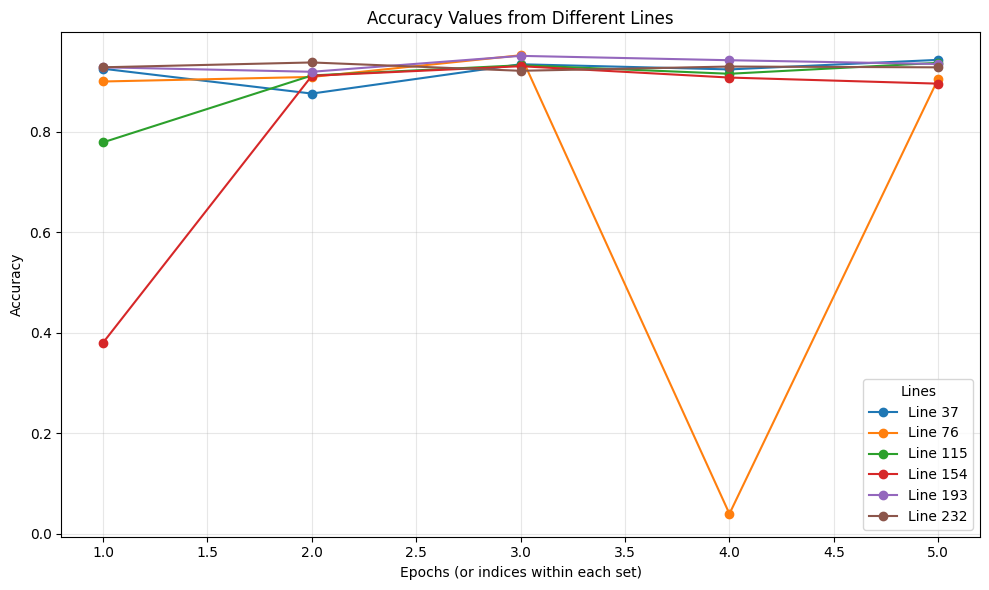

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Data extracted from the lines
lines = [
    [0.9258179664611816, 0.8763362765312195, 0.9347209930419922, 0.9244350790977478, 0.9434680342674255],
    [0.9003887176513672, 0.9094589948654175, 0.9526200890541077, 0.039766743779182434, 0.9058880805969238],
    [0.7792354822158813, 0.9123674035072327, 0.9327771663665771, 0.9157690405845642, 0.9375556707382202],
    [0.38038548827171326, 0.9117265939712524, 0.9308333992958069, 0.9082368016242981, 0.8960881233215332],
    [0.9286524057388306, 0.9197375774383545, 0.9514052271842957, 0.9427391290664673, 0.935206949710846],
    [0.9286524057388306, 0.9382895827293396, 0.9216814041137695, 0.9301854968070984, 0.9285656213760376]
]

# Line numbers corresponding to each set of accuracies
line_numbers = [37, 76, 115, 154, 193, 232]

# Generate the chart
plt.figure(figsize=(10, 6))

# Plot each line of accuracies
for i, acc in enumerate(lines):
    plt.plot(range(1, len(acc) + 1), acc, marker='o', label=f'Line {line_numbers[i]}')

# Add labels, title, and legend
plt.xlabel('Epochs (or indices within each set)')
plt.ylabel('Accuracy')
plt.title('Accuracy Values from Different Lines')
plt.legend(title="Lines", loc='lower right')
plt.grid(alpha=0.3)
plt.tight_layout()

# Display the chart
plt.show()
